In [5]:
import pandas as pd
import numpy as np
from haversine import haversine, Unit
from frechetdist import frdist
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib as mpl
import time
# 在tqdm中注册pandas的apply功能，以便显示进度条
tqdm.pandas()
mpl.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']

# 解决保存图像时负号'-'显示为方块的问题
mpl.rcParams['axes.unicode_minus'] = False


In [6]:
result_df = pd.read_csv("matched_points_for_qgis.csv")
print(result_df.columns)

result_df

Index(['order_id', 'driver_id', 'matched_longitude', 'matched_latitude',
       'point_sequence', 'total_order_distance_m', 'total_order_duration_s',
       'order_avg_confidence'],
      dtype='object')


,order_id,driver_id,matched_longitude,matched_latitude,point_sequence,total_order_distance_m,total_order_duration_s,order_avg_confidence
0,000a7cb982caa7c3a7b0245b6fd3da08,9a9ac4db0843220095674816bcbe28d7,104.066014,30.721599,0,4144.8,477.5,0.00
1,000a7cb982caa7c3a7b0245b6fd3da08,9a9ac4db0843220095674816bcbe28d7,104.066020,30.721598,1,4144.8,477.5,0.00
2,000a7cb982caa7c3a7b0245b6fd3da08,9a9ac4db0843220095674816bcbe28d7,104.066017,30.721599,2,4144.8,477.5,0.00
3,000a7cb982caa7c3a7b0245b6fd3da08,9a9ac4db0843220095674816bcbe28d7,104.066076,30.721591,3,4144.8,477.5,0.00
4,000a7cb982caa7c3a7b0245b6fd3da08,9a9ac4db0843220095674816bcbe28d7,104.066083,30.721667,4,4144.8,477.5,0.00
...,...,...,...,...,...,...,...,...
513471,fff0ee2db1bd1cd98ce4c49cb0cd4851,2eb4c952f0af747168f11dd229936342,104.063349,30.656154,87,1447.4,98.0,0.97
513472,fff0ee2db1bd1cd98ce4c49cb0cd4851,2eb4c952f0af747168f11dd229936342,104.063350,30.656113,88,1447.4,98.0,0.97
513473,fff0ee2db1bd1cd98ce4c49cb0cd4851,2eb4c952f0af747168f11dd229936342,104.063350,30.656103,89,1447.4,98.0,0.97
513474,fff0ee2db1bd1cd98ce4c49cb0cd4851,2eb4c952f0af747168f11dd229936342,104.063353,30.656021,90,1447.4,98.0,0.97


In [7]:
def calculate_original_path_length(points):
    """计算单条原始轨迹的长度（米）"""
    if len(points) < 2:
        return 0.0

    # 使用shift来创建(p_i, p_{i+1})对，然后计算距离
    points_df = pd.DataFrame(points, columns=['latitude', 'longitude'])
    shifted_df = points_df.shift(1)

    distances = [
        haversine((row[0], row[1]), (row[2], row[3]), unit=Unit.METERS)
        for row in np.c_[points_df.values, shifted_df.values][1:] # np.c_用于连接数组，[1:]跳过第一行的NaN
    ]

    return sum(distances)

def process_order_group(original_group, matched_df_map, matched_points_map):
    """
    对单个订单分组进行所有误差计算。
    这是被 groupby().apply() 调用的核心函数。
    """
    order_id = original_group.name

    # 从预处理的Map中快速获取匹配数据
    matched_order_info = matched_df_map.get(order_id)
    matched_order_points = matched_points_map.get(order_id)

    if matched_order_info is None or matched_order_points is None or len(matched_order_points) == 0:
        return None

    original_order_points = original_group[['latitude', 'longitude']].values

    # a. 路径长度计算
    original_length = calculate_original_path_length(original_order_points)
    matched_length = matched_order_info['total_order_distance_m']
    length_difference = matched_length - original_length

    # 确保原始点和匹配点的数量一致用于后续比较
    min_len = min(len(original_order_points), len(matched_order_points))
    if min_len == 0:
        return None

    original_order_points = original_order_points[:min_len]
    matched_order_points = matched_order_points[:min_len]

    # b. 逐点误差 (Point-wise Error)
    pointwise_distances = [haversine(orig, matched, unit=Unit.METERS) for orig, matched in zip(original_order_points, matched_order_points)]
    mean_pointwise_error = np.mean(pointwise_distances) if pointwise_distances else 0
    median_pointwise_error = np.median(pointwise_distances) if pointwise_distances else 0
    max_pointwise_error = np.max(pointwise_distances) if pointwise_distances else 0

    # c. 离散弗雷歇距离 (Discrete Frechet Distance)
    frechet_distance = frdist(original_order_points, matched_order_points)

    # 返回一个Series，会自动被构造成DataFrame的行
    return pd.Series({
        'num_points': min_len,
        'original_path_length_m': original_length,
        'matched_path_length_m': matched_length,
        'path_length_difference_m': length_difference,
        'mean_pointwise_error_m': mean_pointwise_error,
        'median_pointwise_error_m': median_pointwise_error,
        'max_pointwise_error_m': max_pointwise_error,
        'frechet_distance': frechet_distance,
    })


def analyze_map_matching_error_optimized(original_gps_file, matched_gps_file):
    """
    (优化版) 分析地图匹配的订单GPS序列匹配结果误差。
    """
    print("开始分析，正在加载数据...")
    # 1. 加载数据
    try:
        original_df = pd.read_csv(original_gps_file, usecols=['order_id', 'gps_time', 'latitude', 'longitude'])
        matched_df = pd.read_csv(matched_gps_file, usecols=['order_id', 'matched_latitude', 'matched_longitude', 'point_sequence', 'total_order_distance_m'])
    except FileNotFoundError as e:
        print(f"错误: {e}. 请确保文件路径正确。")
        return None

    # 2. 数据预处理
    # 排序原始数据
    original_df['gps_time'] = pd.to_datetime(original_df['gps_time'])
    original_df = original_df.sort_values(by=['order_id', 'gps_time'])

    # 排序匹配数据
    matched_df = matched_df.sort_values(by=['order_id', 'point_sequence'])

    print("数据加载完毕，正在进行预处理...")
    # --- 优化点：预处理匹配数据，存入字典以供快速查询 ---
    # 提取每个订单的聚合信息（如总长度）
    matched_summary = matched_df.groupby('order_id')['total_order_distance_m'].first().reset_index()
    matched_df_map = matched_summary.set_index('order_id').to_dict('index')

    # 提取每个订单的坐标点序列
    matched_points_map = {
        order_id: group[['matched_latitude', 'matched_longitude']].values
        for order_id, group in matched_df.groupby('order_id')
    }

    print("预处理完成，开始对每个订单进行误差计算...")
    # 3. 使用 groupby().apply() 进行核心计算
    start_time = time.time()

    # 对原始数据进行分组
    grouped_original = original_df.groupby('order_id')

    # apply函数会并行或高效地处理每个分组
    error_df = grouped_original.apply(process_order_group, matched_df_map=matched_df_map, matched_points_map=matched_points_map)

    # 清理计算中可能产生的空结果
    error_df = error_df.dropna().reset_index()

    end_time = time.time()
    print(f"误差计算完成，耗时: {end_time - start_time:.2f} 秒")

    return error_df


def plot_error_analysis(error_df):
    """
    可视化误差分析结果。
    """
    if error_df.empty:
        print("没有可供可视化的数据。")
        return

    print("开始生成可视化图表...")
    # 设置绘图风格
    # sns.set_theme(style="whitegrid")

    # 创建一个2x2的子图布局
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('地图匹配误差分析可视化', fontsize=20)

    # 1. 路径长度差值直方图
    sns.histplot(error_df['path_length_difference_m'], kde=True, ax=axes[0, 0], bins=50)
    mean_diff = error_df['path_length_difference_m'].mean()
    axes[0, 0].axvline(mean_diff, color='r', linestyle='--', label=f'平均差值: {mean_diff:.2f} m')
    axes[0, 0].set_title('路径长度差值分布 (匹配长度 - 原始长度)')
    axes[0, 0].set_xlabel('差值 (米)')
    axes[0, 0].set_ylabel('订单数量')
    axes[0, 0].legend()

    # 2. 平均逐点误差直方图
    sns.histplot(error_df['mean_pointwise_error_m'], kde=True, ax=axes[0, 1], color='skyblue', bins=50)
    mean_err = error_df['mean_pointwise_error_m'].mean()
    axes[0, 1].axvline(mean_err, color='r', linestyle='--', label=f'平均误差: {mean_err:.2f} m')
    axes[0, 1].set_title('平均逐点误差 (Haversine Distance) 分布')
    axes[0, 1].set_xlabel('平均误差 (米)')
    axes[0, 1].set_ylabel('订单数量')
    axes[0, 1].legend()

    # 3. 弗雷歇距离直方图
    sns.histplot(error_df['frechet_distance'], kde=True, ax=axes[1, 0], color='green', bins=50)
    mean_frechet = error_df['frechet_distance'].mean()
    axes[1, 0].axvline(mean_frechet, color='r', linestyle='--', label=f'平均距离: {mean_frechet:.2f}')
    axes[1, 0].set_title('弗雷歇距离 (轨迹形状相似度) 分布')
    axes[1, 0].set_xlabel('弗雷歇距离')
    axes[1, 0].set_ylabel('订单数量')
    axes[1, 0].legend()

    # 4. 路径长度差值 vs 弗雷歇距离 散点图
    # 限制显示范围，避免极端值影响可读性
    p_low, p_high = error_df['path_length_difference_m'].quantile([0.01, 0.99])
    f_low, f_high = error_df['frechet_distance'].quantile([0.01, 0.99])
    filtered_plot_df = error_df[
        (error_df['path_length_difference_m'] > p_low) & (error_df['path_length_difference_m'] < p_high) &
        (error_df['frechet_distance'] > f_low) & (error_df['frechet_distance'] < f_high)
    ]
    sns.scatterplot(data=filtered_plot_df, x='frechet_distance', y='path_length_difference_m', ax=axes[1, 1], alpha=0.5, s=10)
    axes[1, 1].set_title('弗雷歇距离 vs 路径长度差值 (剔除1%极端值)')
    axes[1, 1].set_xlabel('弗雷歇距离')
    axes[1, 1].set_ylabel('路径长度差值 (米)')

    # 调整布局并保存
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('map_matching_error_visualization.png', dpi=300)
    print("可视化图表已保存为 'map_matching_error_visualization.png'")
    # plt.show() # 如果在Jupyter Notebook等环境中，可以取消此行注释以直接显示图像

开始分析，正在加载数据...
数据加载完毕，正在进行预处理...
预处理完成，开始对每个订单进行误差计算...


/tmp/ipykernel_269455/1301529266.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  error_df = grouped_original.apply(process_order_group, matched_df_map=matched_df_map, matched_points_map=matched_points_map)


误差计算完成，耗时: 62.21 秒

地图匹配误差分析结果概览:
                           order_id  num_points  original_path_length_m  \
0  000a7cb982caa7c3a7b0245b6fd3da08        76.0             2863.457121   
1  00163fa9f687051e353ad68bb00262c0        66.0             1825.601500   
2  001d033798e83518b4d4dbc7196de395        37.0             1038.631858   
3  0037bd8959be6375c24a35407567d46c        25.0             1064.492927   
4  00519a7236e6f16817719aef6a61de99        78.0             2073.621612   

   matched_path_length_m  path_length_difference_m  mean_pointwise_error_m  \
0                 4144.8               1281.342879              354.296531   
1                 1829.3                  3.698500              306.555339   
2                 1036.2                 -2.431858              245.118143   
3                 1085.7                 21.207073              113.787057   
4                 3008.4                934.778388              343.561771   

   median_pointwise_error_m  max_pointwise_err

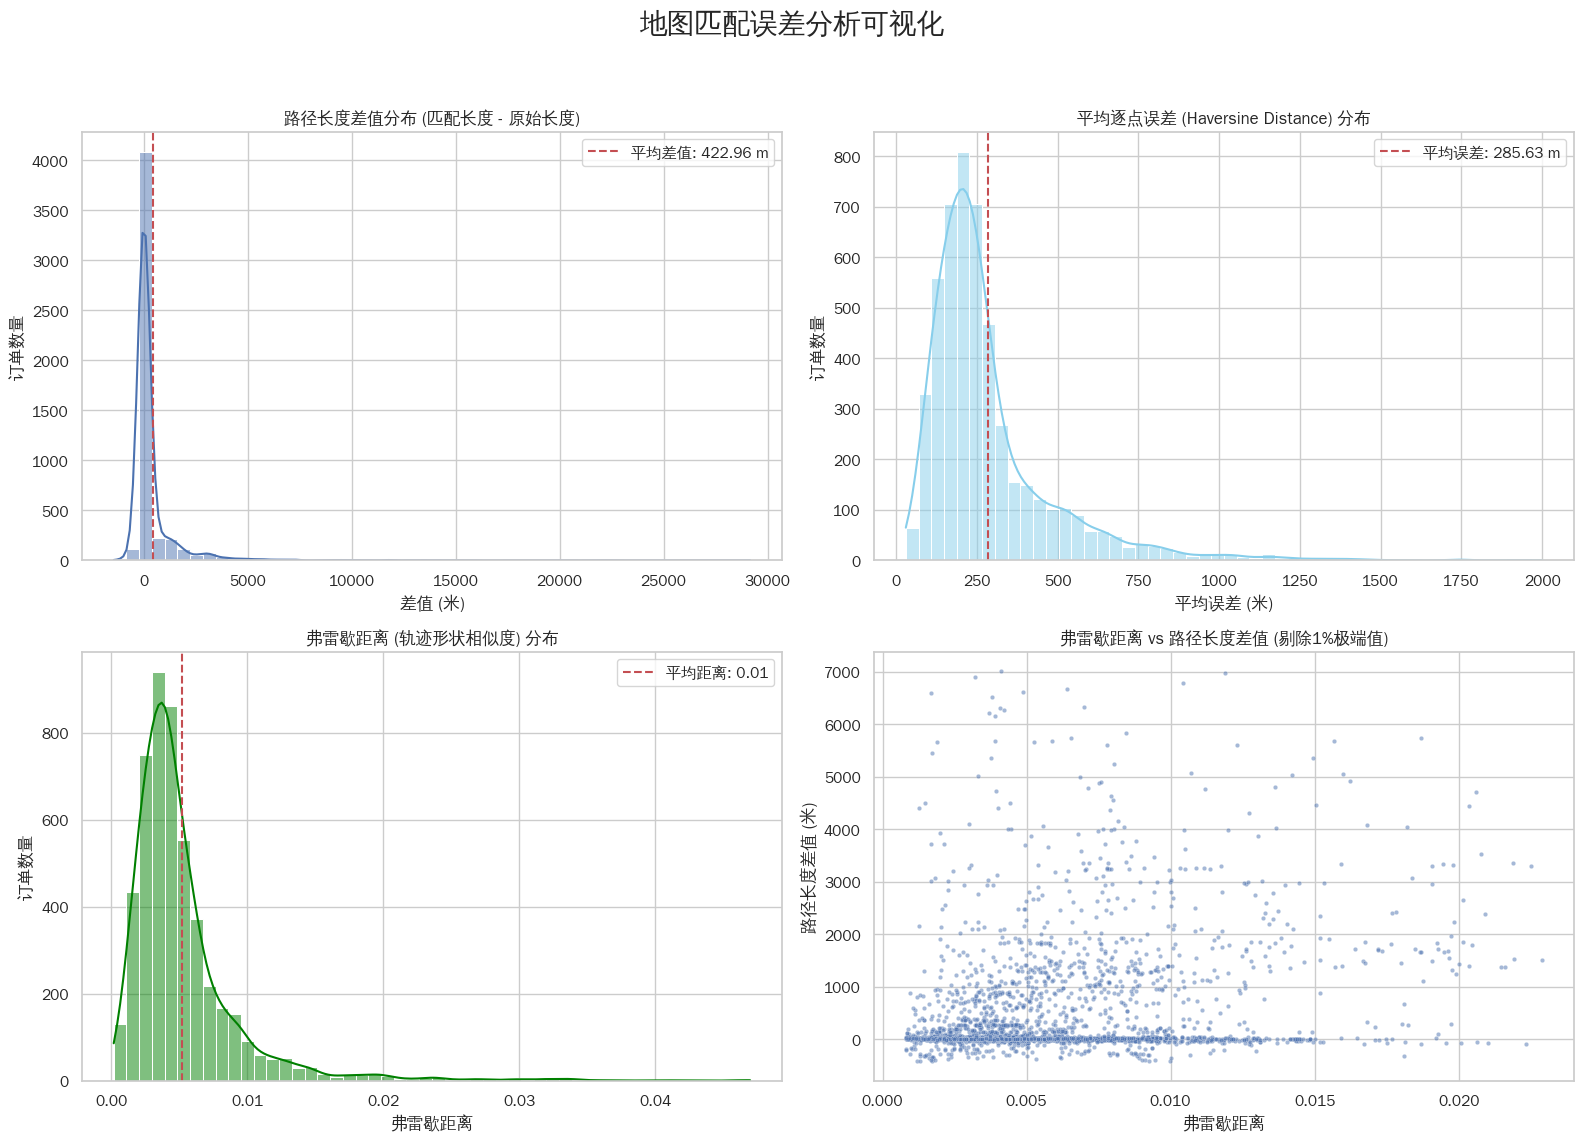

In [8]:
original_gps_file = 'filtered_orders.csv'
matched_gps_file = 'matched_points_for_qgis.csv'


# 执行分析
error_df = analyze_map_matching_error_optimized(original_gps_file, matched_gps_file)

if error_df is not None and not error_df.empty:
    print("\n地图匹配误差分析结果概览:")
    print(error_df.head())

    # 将详细结果保存到新的CSV文件中
    error_df.to_csv('map_matching_error_analysis.csv', index=False)
    print("\n详细分析结果已保存至 'map_matching_error_analysis.csv'")

    # 打印一些总体统计信息
    print("\n总体误差统计:")
    # 选择需要展示的列进行描述
    stats_columns = [
        'original_path_length_m', 'matched_path_length_m', 'path_length_difference_m',
        'mean_pointwise_error_m', 'frechet_distance'
    ]
    print(error_df[stats_columns].describe())

    # 生成并保存可视化图表
    plot_error_analysis(error_df)
else:
    print("分析未生成有效结果。")